In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
data = pd.read_csv('data.csv')
data.head()

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22676 non-null  float64
 1   Apartment type    22676 non-null  object 
 2   Metro station     22676 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22676 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22676 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22676 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.1+ MB


In [5]:
test = pd.DataFrame(data.iloc[:5])
test

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


In [7]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

label.fit(data['Apartment type'].drop_duplicates()) #задаем список значений для кодирования
dicts['Apartment type'] = list(label.classes_)
data['Apartment type'] = label.transform(data['Apartment type']) #заменяем значения из списка кодами закодированных элементов

label.fit(data['Metro station'].drop_duplicates())
dicts['Metro station'] = list(label.classes_)
data['Metro station'] = label.transform(data['Metro station'])

label.fit(data['Region'].drop_duplicates())
dicts['Region'] = list(label.classes_)
data['Region'] = label.transform(data['Region'])

label.fit(data['Renovation'].drop_duplicates())
dicts['Renovation'] = list(label.classes_)
data['Renovation'] = label.transform(data['Renovation'])


In [8]:
import pickle

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label, f)

In [9]:
with open('label_encoder.pkl', 'rb') as f:
   le_loaded = pickle.load(f)


le_loaded.fit(dicts['Apartment type'])
test['Apartment type'] = le_loaded.transform(test['Apartment type'])

le_loaded.fit(dicts['Metro station'])
test['Metro station'] = le_loaded.transform(test['Metro station'])

le_loaded.fit(dicts['Region'])
test['Region'] = le_loaded.transform(test['Region'])

le_loaded.fit(dicts['Renovation'])
test['Renovation'] = le_loaded.transform(test['Renovation'])




In [10]:
params = data[['Price','Minutes to metro', 'Area', 'Living area', 'Kitchen area', 'Number of floors', ]]

Q1 = params.quantile(q=.25)
Q3 = params.quantile(q=.75)
IQR = params.apply(stats.iqr)

data_clean = data[~((params < (Q1-1.5*IQR)) | (params > (Q3+1.5*IQR))).any(axis=1)]

data_clean.shape

(17969, 12)

In [11]:
Y = data_clean.Price.reset_index(drop=True)
X = data_clean.drop(columns=['Price'])

In [12]:
def normalize(df):
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df


def standardize(df):
    return (df - df.mean()) / df.std()



In [13]:
X_normalized = standardize(X).reset_index(drop=True)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size = 0.30, random_state = 18)

In [26]:
def root_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [16]:
import numpy as np

class GDRegressor:
    def __init__(self, alpha=0.001, n_iter=1000, progress=True):
        self.alpha = alpha  
        self.n_iter = n_iter  
        self.progress = progress  
        self.coef_ = None  
        self.intercept_ = None  


    def fit(self, X, Y):
        m, n = X.shape  
        X = np.c_[np.ones(m), X] 
        self.theta = np.zeros(n + 1)  

        for iteration in range(self.n_iter):
            prediction = X.dot(self.theta)
            errors = prediction - Y
            gradient = (1/m) * X.T.dot(errors)
            self.theta -= self.alpha * gradient

            if self.progress and iteration % 100 == 0:
                cost = (1/(2*m)) * np.sum(errors ** 2)
                # print(f"Iteration {iteration}: Cost {cost}")

        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]


    def predict(self, X_test):
        m_test = X_test.shape[0]
        X_test = np.c_[np.ones(m_test), X_test]  
        return X_test.dot(self.theta)



In [17]:
model = GDRegressor(alpha=0.04, n_iter=3000)
model.fit(X_train, Y_train)

In [18]:
def cross_val_score(model, X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    fold_size = X.shape[0] // k
    scores = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        X_val = X[indices[start:end]]
        y_val = y[indices[start:end]]
        X_train = np.concatenate([X[indices[:start]], X[indices[end:]]], axis=0)
        y_train = np.concatenate([y[indices[:start]], y[indices[end:]]], axis=0)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)

In [19]:
cross_val_score(model, np.array(X_normalized), Y)

0.7307831509720293

In [28]:
model = GDRegressor(alpha=0.04, n_iter=3000)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
r2_score(Y_test, predictions), root_mean_squared_error(Y_test, predictions)**0.5

(0.7256380952195076, 4544637.1830483675)

<Axes: ylabel='Price'>

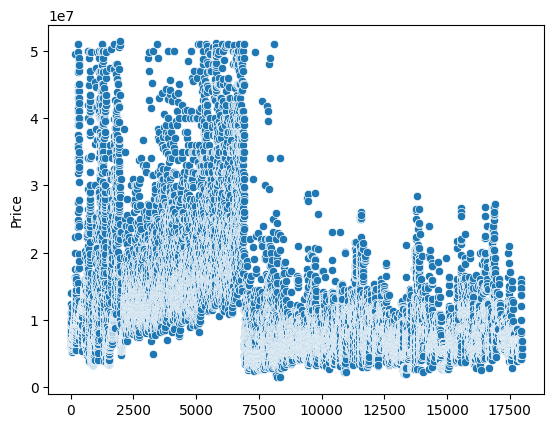

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=Y,  )


In [23]:
data.Price.mean()

36121321.81531134

In [24]:

def predict( X_test, theta):
    m_test = X_test.shape[0]
    X_test = np.c_[np.ones(m_test), X_test]
    return X_test.dot(theta)

vesa = [12089836.01186028,  2865510.08611568,   -32989.92273134,
        -612359.86729597, -1554774.13514984,  -400848.42611825,
        5576276.03285642,    19941.79599452,   254923.59812154,
         324376.45622536,   416419.81924532,  1234254.26881162]


test = pd.DataFrame(list(X_test.iloc[0])).T

res = predict(test, vesa)
res

array([18198464.91686387])